In [ ]:
# Импортируем нужные библиотеки
import vk
import vk_api
import requests
import json
import time
import datetime
import csv
import pandas as pd

In [1]:
# vk_session = vk_api.VkApi()
# vk_session.auth(token_only=True)
# vk_api = vk_session.get_api()
# access_token = ''


In [ ]:
# Загрузим данные по лечебной физкульитуре
df_university = pd.read_excel('tesiaes.xlsx')
df_university

,Name_univer,university,university_faculty,university_chair,city_id
0,МПУ,1187912,2218667,2039208,1
1,РОСНОУ,336,2245483,2188269,1
2,СФУ,1170190,2263535,1849542,73
3,МЭИ,304,797933,2045746,1
4,ИГЭУ Иваново,499,185680,2056551,55
5,ТПУ,853,2098460,2031451,144
6,УРФУ,477,2231275,2101239,49
7,КГЭИ КАЗАНЬ,530,16938,2061713,60
8,САМГТУ,782,2994,2045060,123
9,КузГТУ,550,2151767,2057938,64


### Парсинг USER_ID по году выпуска с направления "Теплоэнергетика"
за период с 2013 по 2022¶

In [ ]:
def search_users1(access_token, year):  # Функция формирования базы участников сообщества в виде списка

    ''' В качестве аргумента функции будет подаваться:
    массив года выпуска из школы и id университета'''
    user_infor_list = []
    for grad_year in year:
        for i in range(len(df_university)):
            first = vk_api.users.search(access_token=access_token,
                                    university= df_university['university'][i],
                                    university_faculty = df_university['university_faculty'][i],
                                    university_chair = df_university['university_chair'][i],
                                    university_year = grad_year,
                                    v=5.131,
                                    count=1000)
            user_infor_list.extend(first['items'])

            user_list = []
            for i in range(len(user_infor_list)):
                user_list.append(user_infor_list[i])                 # Получили JSON

    df_infor = pd.DataFrame(user_list)                           # Создаем датафрейм из JSON

    df_infor = df_infor.query('is_closed == False')               # Фильтруем по открытости страниц

    df_no_duplicates = df_infor.drop_duplicates('id', keep='last') # убираем дубликаты из ДФ и записываем в новый ДФ

    df_no_duplicates.reset_index(inplace=True)                      # сбрасываем индексацию для беребора в цикле

    series_year = df_no_duplicates['id']                           # получаем серию выпускников с 18 года по 21 год


    return series_year


In [ ]:
year = [n for n in range(2008,2023)]
graduate_year = search_users1(access_token, year)

In [ ]:
graduate_year.to_csv('user_id_tes_aes.txt', index=False)
graduate_year_series = pd.read_csv('user_id_tes_aes.txt')
# Посмотрим объем выборки
graduate_year_series

,id
0,385756153
1,716637266
2,381438825
3,563520618
4,531550207
...,...
801,57439472
802,6220109
803,31455284
804,230885047


## Функция получения списка групп по activity. Если сообщество - выодится его тематика "activity" если группа выводится открытая или закрытая.

 Для каждого участника будет выведено 10 групп. Если количество групп, состоящих меньше или пользователь запретил просмотр его групп просто пропускаем. Это делается путем обработки исключений `try / except`

In [ ]:
def groups_id(access_token, series):
    all_groups = []
    for user_id in series:
        time.sleep(1)
        groups = vk_api.groups.get(access_token=access_token,
                                   user_id= user_id,
                                   extended =1,
                                   count=10,
                                   fields = ['activity', 'description'],
                                   v=5.131)
        all_groups.extend(groups['items'])
        alist= []
        for i in range(len(series)):                # Пробегаем циклом собираем группы по 10 штук
            for j in range(10):
                alist.append(i)
    try:
        for z,k in enumerate(alist):
            all_groups[z]['id'] = series[k]         # Каждой группе присваиваем id участника и его activity
    except:
        pass
    return all_groups

In [ ]:
group_grad_10 = groups_id(access_token, graduate_year)

In [ ]:
df_group_10 = pd.DataFrame(group_grad_10)
df_group_10.head(3)

,id,description,activity,name,screen_name,is_closed,type,is_admin,is_member,is_advertiser,photo_50,photo_100,photo_200,deactivated,admin_level
0,385756153,"Группа для тех, кто любит поспать и посмотреть...",Закрытая группа,NHL — Полные Хоккейные Матчи,nhl_matches,1,group,0.0,0.0,0.0,https://sun4-17.userapi.com/s/v1/if2/IkLAzZNt3...,https://sun4-17.userapi.com/s/v1/if2/ZBUn22wvl...,https://sun4-17.userapi.com/s/v1/if2/pW3EtyIlK...,NaN,NaN
1,385756153,Уже с 88 ЛЬДОВ информация от хоккеистов по тре...,Открытая группа,Поиграть в любительский Хоккей ВЕЗДЕ в Москве,hockeyvezde,0,group,0.0,0.0,0.0,https://sun4-20.userapi.com/s/v1/if1/y-YleHFus...,https://sun4-20.userapi.com/s/v1/if1/ZQNhXxTDX...,https://sun4-20.userapi.com/s/v1/if1/g0COlisEB...,NaN,NaN
2,385756153,Единая онлайн система автоматизации подбора пе...,"Консалтинг, бизнес-услуги",QuickStaff,quickstaff_ru,0,page,0.0,0.0,0.0,https://sun4-5.userapi.com/s/v1/ig2/ePvG49bj6L...,https://sun4-5.userapi.com/s/v1/ig2/62Pj5_k3dG...,https://sun4-5.userapi.com/s/v1/ig2/Dmj_QTF4KL...,NaN,NaN


In [ ]:
df_need = df_group_10[['id', 'description', 'activity', 'name', 'screen_name']]
df_need

,id,description,activity,name,screen_name
0,385756153,"Группа для тех, кто любит поспать и посмотреть...",Закрытая группа,NHL — Полные Хоккейные Матчи,nhl_matches
1,385756153,Уже с 88 ЛЬДОВ информация от хоккеистов по тре...,Открытая группа,Поиграть в любительский Хоккей ВЕЗДЕ в Москве,hockeyvezde
2,385756153,Единая онлайн система автоматизации подбора пе...,"Консалтинг, бизнес-услуги",QuickStaff,quickstaff_ru
3,385756153,,Автовладельцы,ЯЖЕВОДИТЕЛЬ,club151016287
4,385756153,Приветствую тебя в Убойном Юморе!\n\nОставь пр...,Открытая группа,УБОЙНЫЙ ЮМОР,club123887615
...,...,...,...,...,...
6936,137765707,КАСКАД ТВ\nНовости Калининградской области. Ме...,Интернет-СМИ,КАСКАД ТВ | Калининградская область|,kaskadntrk
6937,137765707,🤝🏻Добро пожаловать на страницу Калининградског...,"Музей, галерея, выставка",Калининградский зоопарк,kldzoo
6938,137765707,"25 лет пишем о событиях, происшествиях и жизни...",Интернет-СМИ,Комсомольская правда — Калининград,kp_kaliningrad
6939,137765707,Гурьевск (Калининградская область).\n\nИнтерне...,Информационный портал,Мой Гурьевск,mygurievsk


# Обучение модели

In [ ]:
# Загрузим датафрейм для обучения
df1 = pd.read_excel('diploma_this.xlsx')
data_learning = df1.copy()
data_learning.head(3)

,description,activity,name,screen_name,target
0,"Присылайте свои анекдоты в ""Предложите новость...",Юмор,Азохнвей! Бесплатные щикарные анекдоты,azohen_vey,1
1,"Познавательные мемы, широкий охват тем, уникал...",Юмор,Мемуары ценителей научных мемов,sciencemem,1
2,На Хабр Q&A можно получить ответ на вопрос по ...,Программирование,Хабр Q&A,toster_ru,4


### Напишем функцию препроцессинга текстовых данных

Некоторые слова не несут смысловую нагрузку. К таким словам также можно отнести союзы, предлоги, а также знаки препинания. Для экономии времени воспользуемся готовым набором стоп слов

Подготовка текста для обучения состоит из нескольких этапов:

 1. Чистка текста, удаление стоп слов, удаление пунктуации. Замена пустых значений.
 2. Токенизация текста - разбиение текста на токены
 3. Лематизация текста - приведение слова к нормальному типу. Например слово `присылайте` измениться на слово `присылать`
 4. Разбиение на тестовую и обучающую выборку.

In [ ]:
# Фильтр стоп слов
# Загрузим стоп слова
with open ("stopwords-ru.txt", encoding='utf-8') as stop_ru:
    rus_stops = [word.strip() for word in stop_ru.readlines()]
punctuation = '!\"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~—»«...–'
filter = rus_stops + list(punctuation)
# Выведем часть значений из фильтра
filter[:5]

['c', 'а', 'алло', 'без', 'белый']

In [ ]:
# Импорт лематизатора
from pymorphy2 import MorphAnalyzer
parser = MorphAnalyzer()

In [ ]:
from nltk.tokenize import word_tokenize
import re
# Импорт токенезации слов
#from nltk import download as nltk_download     # Паке с токенизатором

#nltk_download("punkt")

In [ ]:
def text_preprocess1(input_text):
    # Удалим все гиперссылки
    text = re.sub(r"https?://[^,\s]+,?", "", input_text)
    # Удалим все цифры
    text = re.sub(r'\d', '', text)
    # Приведем к нижнему регистру
    text = text.lower()
    # Удалим все переносы
    text = text.replace('\n', ' ')
    # Удалим все смайлики
    text = re.sub('[^\x00-\x7Fа-яА-Я]', '', text)
    # Удалим все спецсимволы
    text = re.sub(r"[^a-zA-Z0-9а-яА-Я]", " ", text)

    # удалим id
    text = text.replace('id', '')
    # Удалим более одного пробела
    text = re.sub(r'\s+ ', ' ', text)
    tokenized_text = word_tokenize(text)
    clean_text = [word for word in tokenized_text if word not in filter]
    lemmatized_text = [parser.parse(word)[0].normal_form for word in
                       clean_text]
    lemmatized_text = ' '.join(lemmatized_text)

    return lemmatized_text


In [ ]:
data_learning = data_learning.fillna('Пустое название')
data_learning['description_processed'] = data_learning['description'].astype('str').map(text_preprocess1)
data_learning['activity_processed'] = data_learning['activity'].astype('str').map(text_preprocess1)
data_learning['name_processed'] = data_learning['name'].astype('str').map(text_preprocess1)

# Создадим датафрейм с предобработанными данными
data_learning_2 = data_learning[['description_processed', 'activity_processed', 'name_processed', 'target']].copy()
data_learning_2.head(3)

,description_processed,activity_processed,name_processed,target
0,присылать анекдот предложить новость группа ре...,юмор,азохнвеять бесплатный щикарный анекдот,1
1,познавательный мем широкий охват уникальный ид...,юмор,мемуары ценитель научный мем,1
2,хабра q a ответ любой тема it участник сообщес...,программирование,хабра q a,4


# Загрузка необработанных данных с направлением прикладная информатика

In [ ]:
df_raw_data = pd.read_excel('for_analysis.xlsx', index_col=0)[['id','description', 'activity', 'name']]
df_raw_data

,id,description,activity,name
0,34295316,"Присылайте свои анекдоты в ""Предложите новость...",Юмор,Азохнвей! Бесплатные щикарные анекдоты
1,34295316,"Познавательные мемы, широкий охват тем, уникал...",Юмор,Мемуары ценителей научных мемов
2,34295316,На Хабр Q&A можно получить ответ на вопрос по ...,Программирование,Хабр Q&A
3,34295316,Официальный канал сервиса РБК Инвестиции для т...,Финансы,РБК Инвестиции
4,34295316,"Помогаем новичкам стать веб-разработчиками, а ...",Программирование,Хекслет
...,...,...,...,...
7858,135062551,Британские ученые рекомендуют подписаться на э...,Наука,"Наука и факты | Что будет, если...?"
7859,135062551,"Доставляем суши, пиццу, wok и ещё много чего в...",Доставка еды,Чак Норис | Оренбург: Суши Роллы Пицца Доставка
7860,719190226,Паблик об искусстве и поп-культуре.\n\nСамые г...,Отношения полов,Взрослей
7861,719190226,Внимание! Если вас просят перевести деньги за ...,Творчество,ТФП Оренбург | TFP Orenburg


In [ ]:
# Чистим данные

df_raw_data = df_raw_data.fillna('Пустое название')
df_raw_data['description_processed'] = df_raw_data['description'].astype('str').map(text_preprocess1)
df_raw_data['activity_processed'] = df_raw_data['activity'].astype('str').map(text_preprocess1)
df_raw_data['name_processed'] = df_raw_data['name'].astype('str').map(text_preprocess1)

df_processed_data_math = df_raw_data.copy()

In [ ]:
df_processed_data_math.head(2)

,id,description,activity,name,description_processed,activity_processed,name_processed
0,34295316,"Присылайте свои анекдоты в ""Предложите новость...",Юмор,Азохнвей! Бесплатные щикарные анекдоты,присылать анекдот предложить новость группа ре...,юмор,азохнвеять бесплатный щикарный анекдот
1,34295316,"Познавательные мемы, широкий охват тем, уникал...",Юмор,Мемуары ценителей научных мемов,познавательный мем широкий охват уникальный ид...,юмор,мемуары ценитель научный мем


In [ ]:
# Создадим датафрейм с предобработанными данными
df_processed_data_math_2 = df_processed_data_math[['id','description_processed', 'activity_processed', 'name_processed']].copy()
df_processed_data_math_2.head(2)

,id,description_processed,activity_processed,name_processed
0,34295316,присылать анекдот предложить новость группа ре...,юмор,азохнвеять бесплатный щикарный анекдот
1,34295316,познавательный мем широкий охват уникальный ид...,юмор,мемуары ценитель научный мем


# Модель 2

Идея для модели в следующем, что мы не обычаем модель на двух моделях текст и обучение годен негоден. Делаем склейку текстового пространства, делаем трансформацию в признаки и обучаем сразу на текстовых данных

In [ ]:
df_math = df_processed_data_math_2.copy()
df_math['text_features'] = (df_math['description_processed'] + ' ' +
                            df_math['activity_processed'] + ' '
                            + df_math['name_processed'])

In [ ]:
df_math[['id', 'text_features']]

,id,text_features
0,34295316,присылать анекдот предложить новость группа ре...
1,34295316,познавательный мем широкий охват уникальный ид...
2,34295316,хабра q a ответ любой тема it участник сообщес...
3,34295316,официальный канал сервис рбк инвестиция заботи...
4,34295316,помогать новичок веб разработчик опытный прогр...
...,...,...
7858,135062551,британский учёный рекомендовать подписаться па...
7859,135062551,доставлять сушить пицца wok ещ вкусненький ваш...
7860,719190226,паблик искусство поп культура самый горячий но...
7861,719190226,внимание просить перевести студия карта мошенн...


In [ ]:
# Транспонирование с группировкой
df_group_text_math = df_math.assign(idx=(df_math.groupby("id").cumcount()+1)      \
                                 .astype(str).str.replace("^(.)", "text_features_\\1", regex=True)) \
                                 .pivot(index="id", columns="idx", values="text_features")
df_group_text_math = df_group_text_math.reset_index(0)
df_group_text_math = df_group_text_math.fillna('Пустое значение')
# Создаем таргет
df_group_text_math['target'] = 1

In [ ]:
df_group_text_math.head(2)

idx,id,text_features_1,text_features_10,text_features_2,text_features_3,text_features_4,text_features_5,text_features_6,text_features_7,text_features_8,text_features_9,target
0,67177,информационный ресурс молоджи нижегородский об...,плохой слать совершенно секретно история мысль...,собирать всe интересный жизнь наш город упусти...,чу дпо учебный центр рост осуществлять обучени...,привет попасть паблик посвящнный школьный юмор...,mirfactov сайт интересный факт о всм свет блог...,жать подписаться саровский новость происшестви...,сарказмировать повестка юмор борщ,информационный агентство затоновость саров гор...,клуб человек иначе связанный великобритания оф...,1
1,120886,мочь поделиться любой секрет мем вопрос иметь ...,группа посвятить новый проект студия cartoon n...,постирония ваш p s ссылка персонаж коммент бан...,page where we all pretend to speak english юмо...,добивать убить доктор since шоу передача inse ...,материал заблокировать территория рф основание...,официальный страница санкт петербургский госуд...,пустой название язык japaneseyou японский язык,пустой название творчество armando and ax,пустой название творчество dinozzur,1


### Повторяем то же самое с данными по теплоэнергетике

In [ ]:
# Чистим данные

df_raw_teplo = df_need.fillna('Пустое название')
df_raw_teplo['description_processed'] = df_raw_teplo['description'].astype('str').map(text_preprocess1)
df_raw_teplo['activity_processed'] = df_raw_teplo['activity'].astype('str').map(text_preprocess1)
df_raw_teplo['name_processed'] = df_raw_teplo['name'].astype('str').map(text_preprocess1)

df_processed_data_teplo = df_raw_teplo.copy()

In [ ]:

df_teplo = df_processed_data_teplo.copy()
df_teplo['text_features'] = (df_teplo['description_processed'] + ' ' +
                            df_teplo['activity_processed'] + ' '
                            + df_teplo['name_processed'])

df_teplo.head(2)

,id,description,activity,name,screen_name,description_processed,activity_processed,name_processed,text_features
0,385756153,"Группа для тех, кто любит поспать и посмотреть...",Закрытая группа,NHL — Полные Хоккейные Матчи,nhl_matches,группа любить поспать матч утро правило группа...,закрытый группа,nhl полный хоккейный матч,группа любить поспать матч утро правило группа...
1,385756153,Уже с 88 ЛЬДОВ информация от хоккеистов по тре...,Открытая группа,Поиграть в любительский Хоккей ВЕЗДЕ в Москве,hockeyvezde,лёд информация хоккеист тренировка двусторонка...,открытый группа,поиграть любительский хоккей москва,лёд информация хоккеист тренировка двусторонка...


In [ ]:
df_teplo = df_teplo[['id', 'text_features']]

In [ ]:
# Транспонирование с группировкой
df_group_text_teplo = df_teplo.assign(idx=(df_teplo.groupby("id").cumcount()+1)      \
                                 .astype(str).str.replace("^(.)", "text_features_\\1", regex=True)) \
                                 .pivot(index="id", columns="idx", values="text_features")
df_group_text_teplo = df_group_text_teplo.reset_index(0)
df_group_text_teplo = df_group_text_teplo.fillna('Пустое значение')
# Создаем таргет
df_group_text_teplo['target'] = 0

In [ ]:
df_group_text_teplo.head(2)

idx,id,text_features_1,text_features_10,text_features_2,text_features_3,text_features_4,text_features_5,text_features_6,text_features_7,text_features_8,text_features_9,target
0,2201,спортивный организация vostochniy voin fighti...,легендарный сеть магазин мужской одежда montan...,информативный развлекательный сообщество спорт...,восприниматься буквально юмор буквально,новинка пыл жара кино киномир,новость смешанный единоборство боевой искусств...,туризм путешествие рекорд шок,политика непобедимый,телеграм yt кино marvel dc,предложить интересный история писать предложит...,0
1,494247,друг подписать ждм хороший фильм мультфильм тр...,заказать реклама язык english with pleasure,официальный страница актёр сериал непосредстве...,прочитать блог культура наблюдение высота балк...,достойный фильм вконтакте сообщество размещать...,пост публиковать подписчик внимание наслать жи...,группа предназначить свободный общение житель ...,история отправлять сообщение группа предложить...,группа предназначить объявление различный б то...,знакомство спонсор содержанка новосибирск,0


## Конкатенация моделей

In [ ]:
df_new_model_2 = pd.concat([df_group_text_math, df_group_text_teplo], axis=0).reset_index()

In [ ]:
df_new_model_2 = df_new_model_2[['id','text_features_1', 'text_features_10', 'text_features_2',
       'text_features_3', 'text_features_4', 'text_features_5',
       'text_features_6', 'text_features_7', 'text_features_8',
       'text_features_9', 'target']]

In [ ]:
# Перемешаем датафрейм
from sklearn.utils import shuffle
df_new_model_3 = shuffle(df_new_model_2)

In [ ]:
df_new_model_3.head(3)

idx,id,text_features_1,text_features_10,text_features_2,text_features_3,text_features_4,text_features_5,text_features_6,text_features_7,text_features_8,text_features_9,target
1091,75838141,добро пожаловать группа оказывать помощь студе...,mdk международный молодёжный комьюнити создать...,заимствование материал сообщество допускаться ...,champions cup самый больший страница вконтакте...,club nr новостной сообщество окружать интернет...,club nr music музыкальный сообщество музыка ко...,ютуба блогер стример собирать пк любой сложнос...,рипа новостной ресурс о всм обсуждать молодёжь...,готовить доставлять пицца ролл волгореченск за...,заказывать lamoda максимальный скидка писать l...,0
1449,629946381,ребёнок чувство юмор смешить плакать юмор ребёнок,сарказмировать повестка юмор борщ,кино badcomedian,вдохновение проявление интересный новость стра...,mdk международный молодёжный комьюнити создать...,стать свидетель авария преступление пожар друг...,самый крупный игровой сообщество простор снг и...,интеллект безумие юмор кф,юмор встретить столбняк,собирать самый хороший арт один место добавлят...,0
1150,112089191,преимущество коммуникабельный легко комфортно ...,сарказмировать повестка юмор борщ,познавательный сообщество развиваться регресси...,правило комментирование предложение новость го...,иллюстратор научить рисовать ученик пройти кур...,водный туризм один немногий сообщество водный ...,официальный сообщество российский общедоступны...,телега юмор кб,уникальный ежедневный поток людской откровение...,объединение спортивно технический клуб томский...,0


In [ ]:
df_new_model_3.columns

Index(['id', 'text_features_1', 'text_features_10', 'text_features_2',
       'text_features_3', 'text_features_4', 'text_features_5',
       'text_features_6', 'text_features_7', 'text_features_8',
       'text_features_9', 'target'],
      dtype='object', name='idx')

In [ ]:
# Указываем признаки
# Текстовые и категориальные признаки
text_features = ['text_features_1', 'text_features_10', 'text_features_2',
       'text_features_3', 'text_features_4', 'text_features_5',
       'text_features_6', 'text_features_7', 'text_features_8',
       'text_features_9']

In [ ]:
df_new_model_4 = df_new_model_3[['text_features_1', 'text_features_10', 'text_features_2',
       'text_features_3', 'text_features_4', 'text_features_5',
       'text_features_6', 'text_features_7', 'text_features_8',
       'text_features_9', 'target']]

In [ ]:
from catboost import CatBoostClassifier
from catboost import Pool
#имортируем функцию, позволяющую делить выборку на тестовую и тренировочную в случайном порядке:
from sklearn.model_selection import train_test_split
#имортируем функцию, позволяющую делить выборку на тестовую и тренировочную в случайном порядке:
from sklearn.model_selection import train_test_split
# Классификационные метрики
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix # функция для визуализации матрицы ошибок

In [ ]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(df_new_model_4.drop('target', axis=1),
                                                    df_new_model_4['target'], test_size=.3,
                                                    random_state=7575)

In [ ]:
# Функция для обучения модели
def fit_model_2(train_pool, validation_pool, **kwargs):
    model = CatBoostClassifier(
        depth = 6,
        iterations=1000,
        learning_rate=0.07,
        eval_metric='Accuracy', #'Accuracy'
        task_type='GPU',
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=500,
    )


In [ ]:
train_pool = Pool(
    X_train4, y_train4,
    text_features=text_features
)

validation_pool = Pool(
    X_test4, y_test4,
    text_features=text_features
)

print('Train dataset shape: {}\n'.format(train_pool.shape))

model_fin2 = fit_model_2(train_pool, validation_pool,
                 dictionaries = [{
                     'dictionary_id':'Word',
                     'max_dictionary_size': '50000'
                 }], feature_calcers =['BoW:top_tokens_count = 10000'])



print('Train dataset shape: {}\n'.format(train_pool.shape))

Train dataset shape: (1037, 10)

0:	learn: 0.7675988	test: 0.7123596	best: 0.7123596 (0)	total: 302ms	remaining: 5m 1s
500:	learn: 0.9971070	test: 0.8584270	best: 0.8696629 (201)	total: 30.3s	remaining: 30.2s
999:	learn: 0.9980714	test: 0.8516854	best: 0.8696629 (201)	total: 59.9s	remaining: 0us
bestTest = 0.8696629213
bestIteration = 201
Shrink model to first 202 iterations.
Train dataset shape: (1037, 10)



In [ ]:
# Посчитаем предсказанные значения на тестовой выборке
y_preds_model_fin2 = model_fin2.predict(X_test4)
print('CatBOOST')
print(classification_report(y_test4, y_preds_model_fin2))

CatBOOST
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       212
           1       0.93      0.81      0.87       233

    accuracy                           0.87       445
   macro avg       0.87      0.87      0.87       445
weighted avg       0.88      0.87      0.87       445



# Напишем функцию, которая выводит список id выпускников г Томска в 2023 году

In [ ]:
def search_users_school(access_token, year):  # Функция формирования базы участников сообщества в виде списка

    ''' В качестве аргумента функции будет подаваться:
    массив года выпуска из школы и id университета'''
    user_infor_list = []

    first = vk_api.users.search(access_token=access_token, city_id = 144, school_year = year,
                                    v=5.131,
                                    count=1000)
    user_infor_list.extend(first['items'])

    user_list = []
    for i in range(len(user_infor_list)):
        user_list.append(user_infor_list[i])                 # Получили JSON

    df_infor = pd.DataFrame(user_list)                           # Создаем датафрейм из JSON

    df_infor = df_infor.query('is_closed == False')               # Фильтруем по открытости страниц

    df_no_duplicates = df_infor.drop_duplicates('id', keep='last') # убираем дубликаты из ДФ и записываем в новый ДФ

    df_no_duplicates.reset_index(inplace=True)                      # сбрасываем индексацию для беребора в цикле

    series_year = df_no_duplicates['id']                           # получаем серию выпускников с 18 года по 21 год


    return series_year


In [ ]:
series_school_2023 = search_users_school(access_token, 2023)

### Применим функцию поиска групп

In [ ]:
group_school_10 = groups_id(access_token, series_school_2023)

In [ ]:
df_group_school_10 = pd.DataFrame(group_school_10)
df_group_school_10

,id,description,activity,name,screen_name,is_closed,type,is_admin,is_member,is_advertiser,photo_50,photo_100,photo_200,deactivated
0,43293201,Познавательные посты сообщества pikabu.ru,Образование,Пикабу Познавательный,knowledge_pikabu,0,page,0.0,0.0,0.0,https://sun4-15.userapi.com/s/v1/ig2/BZw0Z_h2L...,https://sun4-15.userapi.com/s/v1/ig2/sTpn3I5pd...,https://sun4-15.userapi.com/s/v1/ig2/yhq67bhQV...,NaN
1,43293201,"""Это Сибирь!"" - проект, посвященный Сибири, её...","Туризм, путешествия","Это Сибирь! | Алтай, Байкал. Путешествия.",etosibir,0,page,0.0,0.0,0.0,https://sun4-20.userapi.com/s/v1/if1/GTNh-x08k...,https://sun4-20.userapi.com/s/v1/if1/tQ1p6onGw...,https://sun4-20.userapi.com/s/v1/if1/swam52bfb...,NaN
2,43293201,Слова – это лишь тени того бесчисленного множе...,Литература,Читающие,club42968101,0,page,0.0,0.0,0.0,https://sun4-18.userapi.com/s/v1/if2/kx5ioB1db...,https://sun4-18.userapi.com/s/v1/if2/YCbnDvlRX...,https://sun4-18.userapi.com/s/v1/if2/K5_bqBFlD...,NaN
3,43293201,Самые свежие новости Томска и Томской области....,Интернет-СМИ,Портал vtomske.ru,vtomskeru,0,page,0.0,0.0,0.0,https://sun4-19.userapi.com/s/v1/if1/XwYm0DG2K...,https://sun4-19.userapi.com/s/v1/if1/GbJzlnj2B...,https://sun4-19.userapi.com/s/v1/if1/CgGJ7qe7h...,NaN
4,43293201,❗ЗАКАЗЫ ПРИНИМАЕМ ТОЛЬКО В СООБЩЕНИЯХ СООБЩЕСТ...,"Стиль, одежда, обувь",СОМ - украшения ручной работы,domsoma,0,page,0.0,0.0,0.0,https://sun4-19.userapi.com/s/v1/if1/1VeDZqBDq...,https://sun4-19.userapi.com/s/v1/if1/eElCzZInl...,https://sun4-19.userapi.com/s/v1/if1/Qg29IsZ5k...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6597,696440917,🐾 Все животные – это полноправные жители нашей...,Домашние и дикие животные,Животные – мои друзья,zoovesti,0,page,0.0,0.0,0.0,https://sun4-21.userapi.com/s/v1/ig2/6u1fBtDHu...,https://sun4-21.userapi.com/s/v1/ig2/Wkjy7HbEM...,https://sun4-21.userapi.com/s/v1/ig2/6SdtXb8cH...,NaN
6598,696440917,самый первый и самый олдовый 📓\n\nищите свои д...,Юмор,мам ну не читай,momdontread,0,page,0.0,0.0,0.0,https://sun4-22.userapi.com/s/v1/if1/uTop7D8zH...,https://sun4-22.userapi.com/s/v1/if1/6pNnUXAfz...,https://sun4-22.userapi.com/s/v1/if1/DFkBCa317...,NaN
6599,696440917,"Государственный Эрмитаж обладает коллекцией, н...","Музей, галерея, выставка",Государственный Эрмитаж,hermitage_museum,0,page,0.0,0.0,0.0,https://sun4-17.userapi.com/s/v1/ig2/6YvisCwPS...,https://sun4-17.userapi.com/s/v1/ig2/MYL5WbF3G...,https://sun4-17.userapi.com/s/v1/ig2/eUg3-cl0n...,NaN
6600,622982875,Переводим и озвучиваем научно-популярные видео...,Наука,VERT DIDER,studio_vd,0,page,0.0,0.0,0.0,https://sun4-19.userapi.com/s/v1/if1/Z3GvlCfYC...,https://sun4-19.userapi.com/s/v1/if1/_HNbH7VaE...,https://sun4-19.userapi.com/s/v1/if1/2lu16RX3l...,NaN


In [ ]:
df_need_school = df_group_school_10[['id', 'description', 'activity', 'name', 'screen_name']]
df_need_school

,id,description,activity,name,screen_name
0,43293201,Познавательные посты сообщества pikabu.ru,Образование,Пикабу Познавательный,knowledge_pikabu
1,43293201,"""Это Сибирь!"" - проект, посвященный Сибири, её...","Туризм, путешествия","Это Сибирь! | Алтай, Байкал. Путешествия.",etosibir
2,43293201,Слова – это лишь тени того бесчисленного множе...,Литература,Читающие,club42968101
3,43293201,Самые свежие новости Томска и Томской области....,Интернет-СМИ,Портал vtomske.ru,vtomskeru
4,43293201,❗ЗАКАЗЫ ПРИНИМАЕМ ТОЛЬКО В СООБЩЕНИЯХ СООБЩЕСТ...,"Стиль, одежда, обувь",СОМ - украшения ручной работы,domsoma
...,...,...,...,...,...
6597,696440917,🐾 Все животные – это полноправные жители нашей...,Домашние и дикие животные,Животные – мои друзья,zoovesti
6598,696440917,самый первый и самый олдовый 📓\n\nищите свои д...,Юмор,мам ну не читай,momdontread
6599,696440917,"Государственный Эрмитаж обладает коллекцией, н...","Музей, галерея, выставка",Государственный Эрмитаж,hermitage_museum
6600,622982875,Переводим и озвучиваем научно-популярные видео...,Наука,VERT DIDER,studio_vd


In [ ]:
# Чистим данные по школе

df_raw_school = df_need_school.fillna('Пустое название')
df_raw_school['description_processed'] = df_raw_school['description'].astype('str').map(text_preprocess1)
df_raw_school['activity_processed'] = df_raw_school['activity'].astype('str').map(text_preprocess1)
df_raw_school['name_processed'] = df_raw_school['name'].astype('str').map(text_preprocess1)

df_processed_data_school = df_raw_school.copy()


In [ ]:
df_school = df_processed_data_school.copy()
df_school['text_features'] = (df_school['description_processed'] + ' ' +
                            df_school['activity_processed'] + ' '
                            + df_school['name_processed'])

df_school.head(2)

,id,description,activity,name,screen_name,description_processed,activity_processed,name_processed,text_features
0,43293201,Познавательные посты сообщества pikabu.ru,Образование,Пикабу Познавательный,knowledge_pikabu,познавательный пост сообщество pikabu ru,образование,пикаба познавательный,познавательный пост сообщество pikabu ru образ...
1,43293201,"""Это Сибирь!"" - проект, посвященный Сибири, её...","Туризм, путешествия","Это Сибирь! | Алтай, Байкал. Путешествия.",etosibir,сибирь проект посвятить сибирь удивительный пр...,туризм путешествие,сибирь алтай байкал путешествие,сибирь проект посвятить сибирь удивительный пр...


In [ ]:
df_school = df_school[['id', 'text_features']]
df_school.head(3)

,id,text_features
0,43293201,познавательный пост сообщество pikabu ru образ...
1,43293201,сибирь проект посвятить сибирь удивительный пр...
2,43293201,слово тень бесчисленный множество мысль пребыв...


In [ ]:
# Транспонирование с группировкой
df_group_text_school = df_school.assign(idx=(df_school.groupby("id").cumcount()+1)      \
                                 .astype(str).str.replace("^(.)", "text_features_\\1", regex=True)) \
                                 .pivot(index="id", columns="idx", values="text_features")
df_group_text_school = df_group_text_school.reset_index(0)
df_group_text_school = df_group_text_school.fillna('Пустое значение')
df_group_text_school.head(3)

idx,id,text_features_1,text_features_10,text_features_2,text_features_3,text_features_4,text_features_5,text_features_6,text_features_7,text_features_8,text_features_9
0,10276058,хороший свой дело быстрый вывод самый окупать ...,единственный официальный паблик стример parade...,вконтакте marmok,блогер поззь,новый ждм блогер михаил литвин,grand role play игровой проект gta roleplay ре...,привет кочевник добро пожаловать сервер del pe...,уникальный бот игра возможность заработать сти...,модель ева элфи eva elfie,работать игра дот аегис работать
1,14734162,vk play cloud сервис облачный гейминг позволят...,привет выложить объявление написать предложить...,наш студия найти художественный татуировка ска...,дорогой участник прежде опубликовать запись ад...,мочь продать либо купить интересовать колесо с...,самый регион паблик иначе интересоваться жизнь...,дорогой участник прежде опубликовать запись ад...,кузовной ремонт томск работа любой сложность п...,дорогой участник прежде опубликовать запись ад...,стиль искусство работать отправка весь россия ...
2,43293201,познавательный пост сообщество pikabu ru образ...,русский географический общество один старый ге...,сибирь проект посвятить сибирь удивительный пр...,слово тень бесчисленный множество мысль пребыв...,самый свежий новость томск томский область вст...,заказ принимать сообщение сообщество вс расска...,добро пожаловать уголок приглашать окунуться а...,бренд авторский ювелирный изделие москва qari ...,хижина тень дерево микро минь жилить ландшафтн...,хотеть быстро продать эублефара корм рептилия ...


In [ ]:
# Указываем признаки
# Текстовые и категориальные признаки
text_features = ['text_features_1', 'text_features_10', 'text_features_2',
       'text_features_3', 'text_features_4', 'text_features_5',
       'text_features_6', 'text_features_7', 'text_features_8',
       'text_features_9']

In [ ]:
df_pred_school = df_group_text_school[text_features].copy()
df_pred_school.head(2)

idx,text_features_1,text_features_10,text_features_2,text_features_3,text_features_4,text_features_5,text_features_6,text_features_7,text_features_8,text_features_9
0,хороший свой дело быстрый вывод самый окупать ...,единственный официальный паблик стример parade...,вконтакте marmok,блогер поззь,новый ждм блогер михаил литвин,grand role play игровой проект gta roleplay ре...,привет кочевник добро пожаловать сервер del pe...,уникальный бот игра возможность заработать сти...,модель ева элфи eva elfie,работать игра дот аегис работать
1,vk play cloud сервис облачный гейминг позволят...,привет выложить объявление написать предложить...,наш студия найти художественный татуировка ска...,дорогой участник прежде опубликовать запись ад...,мочь продать либо купить интересовать колесо с...,самый регион паблик иначе интересоваться жизнь...,дорогой участник прежде опубликовать запись ад...,кузовной ремонт томск работа любой сложность п...,дорогой участник прежде опубликовать запись ад...,стиль искусство работать отправка весь россия ...


In [ ]:
df_pred_school['target'] = model_fin2.predict(df_pred_school)

<AxesSubplot: >

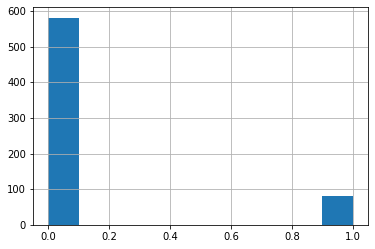

In [ ]:
df_pred_school['target'].hist()

### Вывод

Была составлена модель для предсказания обучения (прикладная математика и теплоэнергетика). Прикладная информатика кодируется 1, теплоэнергетика -0.
Были собраны данные сырые по выпускникам города Томска.
Данные были предобработаны для подачи их в модель.
В ходе предсказания данных получилось, что тех кто ярко-выраженный для математики менее 100 человек(1), остальные теплоэнергетики.
На самом деле это не так, так как изначально стоит классифицировать выраженность направленности обучения (гумманитарий, технические дисциплины, матьематика итд).
Этот классификатор покажет более точную картину на подаче данных (тех дисциплины и математика)